# Classification of DC events based  on Techn. Indicators

This file loads samples froma pickle file, created inside Directional_Change_ATR.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.metrics import average_precision_score, roc_curve, auc,recall_score,precision_score
import pickle


In [39]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [41]:
samples_filename="./tmp/atr_dc_minmax52.pkl"
samples=pickle.load(open(samples_filename, "rb"))
feature_names=[]
for ki in samples[0].keys():
    if (not "profit" in ki) and (not "t+" in ki) and isfloat(samples[0].get(ki)):
        feature_names.append(ki)
        #["dt", "hour[t]", "emacd[t]", "dcma", "prevdc", "dev"]
#feature_names=["dt", "emacd[t]", "dcma"]
print("Using feature names: "+str(feature_names))



Using feature names: ['hour[t]', 'emacd[t]', 'prev_osup', 'prev_osdown', 'dcma', 'prevdc', 'eps_setting', 'dev', 'dt']


In [44]:
def samples2mldata(samples, keys, conditional_event="dcup", true_key="dc"):
    """
    conditional_event: select only samples where evt[t-1]==conditional_event
    """
    

    x=[]
    y=[]
    for si in samples:
        if si['evt[t-1]']!=conditional_event:
            continue
        yi=true_key in si['evt[t+0]']
        y.append(int(yi))
        xi=[si.get(key) for key in keys if isfloat(si.get(key))]
        x.append(xi)
    x=np.array(x)
    y=np.array(y)
    return x,y


    

In [48]:
x,y=samples2mldata(samples, keys=all_keys)
print(x.shape)
print(y.shape)
print(x[0])
print(samples[0])
print("\nfeature names: "+str(feature_names))

(2222, 9)
(2222,)
[ 1.50000000e+01 -3.28933333e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.00000000e+00  5.00000000e-01  2.50000000e-05
  2.70000000e+01]
{'profit[t]': 0, 'evt[t-1]': 'osd', 'evt[t+0]': 'dcdown', 'evt[t+1]': 'dcup', 'hour[t]': 15, 'emacd[t]': -0.003011666666666857, 'month': '2020-1', 'prev_osup': 0, 'prev_osdown': 0, 'dcma': 0.0, 'prevdc': 0, 'eps_setting': 0.5, 'dev': 0.00014000000000025103, 'dt': 40.0}

feature names: ['hour[t]', 'emacd[t]', 'prev_osup', 'prev_osdown', 'dcma', 'prevdc', 'eps_setting', 'dev', 'dt']


In [92]:
#https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
def fair_obj(preds, dtrain):
    """y = c * abs(x) - c**2 * np.log(abs(x)/c + 1)"""
    x = preds - dtrain.get_label()
    c = 10 #free param
    den = abs(x) + c
    grad = c*x / den
    hess = c*c / den ** 2
    return grad, hess

def compute_score(yp, ygt, thr):
    n=yp.shape[0]
    correct=0
    for i in range(ygt.shape[0]):
        if yp[i]>thr and ygt[i]>0: #==yp[i]:
            correct+=1
    return correct/float(n)

def learn(x,y, epochs, eta, feature_names, train_idx, test_idx, plot_roc=True):
    x_train=x[train_idx]
    y_train=y[train_idx]
    x_test=x[test_idx]
    y_test=y[test_idx]
    
    #print(x_train)
    dtest = xgb.DMatrix(data=x_test,label=y_test, feature_names=feature_names)
    dtrain = xgb.DMatrix(data=x_train,label=y_train, feature_names=feature_names)
    
    

    param = {'max_depth': 2, 'eta': eta}#, 'verbose':1, 'verbose_eval':True}#'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = ['auc']#, 'aucpr', 'error']
    evallist = [(dtest, 'test'), (dtrain, 'train')]
    int_epochs = int(epochs)

    bst = xgb.train(param, dtrain, int_epochs, evallist, verbose_eval=0, obj=fair_obj)#, feval=cb_wrong_entries)
    #xgb.plot_importance(bst)


    yp_prob=bst.predict(dtest)
    #print("yp_prob.shape: "+str(yp_prob.shape))
    yp_prob=yp_prob.reshape((yp_prob.shape[0], 1))

    yp_prob_train=bst.predict(dtrain).reshape((-1, 1))


    #print("#entries: "+str(res['total']))
    #print("#wrong: "+str(res['wrong']))
    #return 1-res['wrong']/res['total']

    score = average_precision_score(y_test, yp_prob)
    num_entries=0
    num_wrong=0
    fpr, tpr, _ = roc_curve(y_test, yp_prob)
    roc_auc = auc(fpr, tpr)
    print('AUC: {:.6f}'.format(roc_auc))
    if plot_roc:
        
        #plt.show()
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.02, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
        xgb.plot_importance(bst)
        
    res={'y_test': y_test, 'y_proba_pred': yp_prob}
    return res
        
    #store model to disk
    #from joblib import dump, load
    #model_outfile='../PretrainedModels/hmaCls_'+predict_target+'_hma'+str(hma_n)+'_'+str(summary)+'_nf'+str(len(selected_features))+'_thr'+str(classification_profit_threshold)+"_fh"+str(future_horizons[0])+'.joblib'
    #print("Saving model under "+model_outfile)
    #dump(bst, model_outfile)
    #return {'yprob_train':yp_prob_train, 'yprob_test':yp_prob, 'test_index':test_index, 'train_index':train_index, 'num_entries': num_entries, 'num_wrong':num_wrong, 'AUC':score}


In [93]:
def clean_feature_names(feature_names):
    #removes unwanted characters such a s[ and <
    out_names=[]
    for fi in feature_names:
        b = "[]><="
        outi=fi
        for char in b:
            outi = outi.replace(char,"")
        out_names.append(outi)
    return out_names


## Train without splits (overfitting)

['hourt', 'emacdt', 'prev_osup', 'prev_osdown', 'dcma', 'prevdc', 'eps_setting', 'dev', 'dt']
AUC: 0.650811


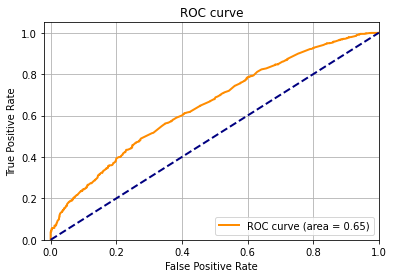

{'y_test': array([1, 0, 0, ..., 1, 1, 1]),
 'y_proba_pred': array([[0.5614012 ],
        [0.4470598 ],
        [0.5003018 ],
        ...,
        [0.8692841 ],
        [0.49157706],
        [0.49157706]], dtype=float32)}

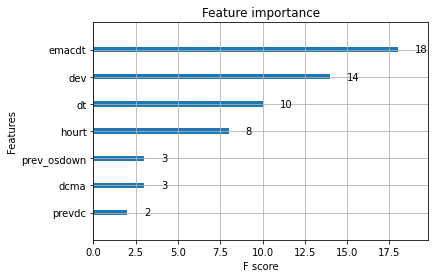

In [94]:

x,y=samples2mldata(samples, keys=feature_names, 
                   conditional_event="dcup", true_key="os")

train_idx=test_idx=list(range(x.shape[0]))

fnames=clean_feature_names(feature_names)
print(fnames)
learn(x,y, epochs=20, eta=0.25, train_idx=train_idx, test_idx=test_idx, feature_names=fnames)

## Train with Split 0.5

['hourt', 'emacdt', 'prev_osup', 'prev_osdown', 'dcma', 'prevdc', 'eps_setting', 'dev', 'dt']
AUC: 0.509468


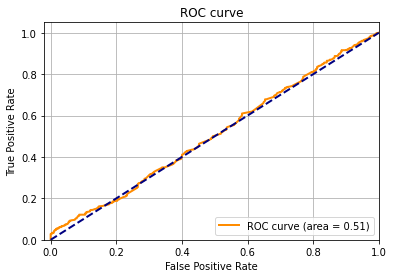

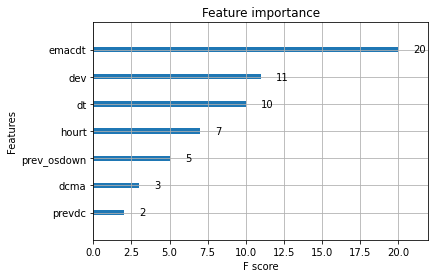

In [95]:

train_idx=list(range(int(x.shape[0]/2)))
test_idx=list(range(int(x.shape[0]/2), x.shape[0]))


fnames=clean_feature_names(feature_names)
print(fnames)
learn_result=learn(x,y, epochs=20, eta=0.25, train_idx=train_idx, test_idx=test_idx, 
      feature_names=fnames)



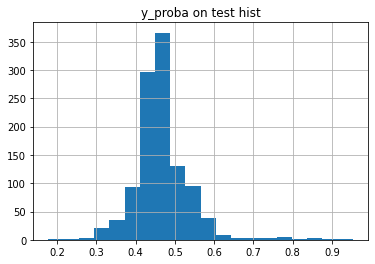

In [96]:
plt.hist(learn_result['y_proba_pred'], bins=20)
plt.title("y_proba on test hist")
plt.grid()


Text(0.5, 1.0, 'Precision over proba prediction threshold')

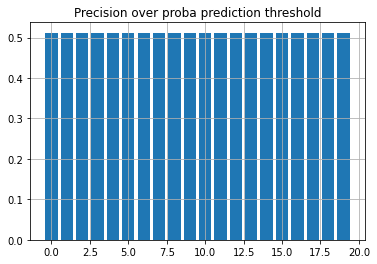

In [98]:
scores=[]
for thr in np.linspace(0.5, 0.9, 20):
    score=compute_score(learn_result['y_test'], learn_result['y_proba_pred'], thr)
    scores.append(score)
    #print(score)
plt.bar(list(range(len(scores))), scores)
plt.grid()
plt.title("Precision over proba prediction threshold")


## Train with Timeseries Split

In [78]:
fnames=clean_feature_names(feature_names)
tscv=TimeSeriesSplit(n_splits=10)
for train_index, test_index in tscv.split(x):
    print("#train: "+str(len(train_index))+", #test: "+str(len(test_index)))
    learn_result=learn(x,y, epochs=20, eta=0.2, 
                       train_idx=train_index, test_idx=test_index,
                       feature_names=fnames, plot_roc=False)
    

#train: 202, #test: 202
AUC: 0.518987
#train: 404, #test: 202
AUC: 0.566306
#train: 606, #test: 202
AUC: 0.509327
#train: 808, #test: 202
AUC: 0.494903
#train: 1010, #test: 202
AUC: 0.531039
#train: 1212, #test: 202
AUC: 0.430715
#train: 1414, #test: 202
AUC: 0.616578
#train: 1616, #test: 202
AUC: 0.544080
#train: 1818, #test: 202
AUC: 0.559998
#train: 2020, #test: 202
AUC: 0.571022


(array([ 5.,  5.,  3., 37., 88., 48.,  5.,  8.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.37376752, 0.39892584, 0.42408413, 0.44924244, 0.47440073,
        0.49955904, 0.52471733, 0.5498756 , 0.57503396, 0.60019225,
        0.62535053, 0.6505089 , 0.67566717, 0.70082545, 0.72598374,
        0.7511421 , 0.7763004 , 0.80145866, 0.82661694, 0.8517753 ,
        0.8769336 ], dtype=float32),
 <BarContainer object of 20 artists>)

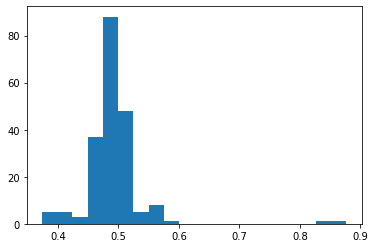

In [80]:
plt.hist(learn_result['y_proba_pred'], bins=20)

## Summary 0

the regimes change quite quickly. What works well on train data does not work on test data on future months.

What can we do aout it?
* apply time based splits (cv) and average over the split results
* start sytematic search for features
